In [4]:
#importing libraries
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import re

In [5]:
print(tf.__version__)

2.3.0


In [6]:
inp=pd.read_csv('./function_tokens.txt',names=['functions'])

In [7]:
inp.head()

,functions
0,while return
1,chi return
2,return cal
3,cross return
4,getpointonline return


In [8]:
target=pd.read_csv('./docstrings.txt',names=['docstrings'])

In [9]:
target.head()

,docstrings
0,greatest common divisor using euclid s algorithm
1,returns the aligned mass weighted spin differe...
2,calculate bulk modulus wrapper for cal k bm3 c...
3,return the crossproduct of the two vectors as ...
4,returns the x y tuple of the point that has pr...


In [10]:
dataset = tf.data.Dataset.from_tensor_slices((inp.values, target.values))

In [13]:
import tokenizers

In [15]:
# We will be using the BertWordPieceTokenizer instead of the SubWordTokenizer in tensorflow

#Docstring tokenizer
tokenizer_doc = tokenizers.BertWordPieceTokenizer(
    strip_accents=True,
    lowercase=True,
    wordpieces_prefix='##'
)

In [16]:
#Generating the vocabulary of 30000 words from the docstrings
tokenizer_doc.train(
    files=['docstrings.txt'],
    vocab_size=30000,
    min_frequency=2,
    limit_alphabet=1000
)

In [17]:
#encoding using the docstring tokenizer
encoded = tokenizer_doc.encode('transformer is awesome')
print(encoded.ids) # Getting the ids for the docstring tokens
print(encoded.tokens) # Getting the docstring tokens

[4436, 126, 19000]
['transformer', 'is', 'awesome']


In [30]:
#Function tokenizer
tokenizer_func = tokenizers.BertWordPieceTokenizer(
    strip_accents=True,
    lowercase=True,
    wordpieces_prefix='##'
)

In [31]:
#Generating the vocabulary of 30000 words from the function tokens
tokenizer_func.train(
    files=['./function_tokens.txt'],
    vocab_size=30000,
    min_frequency=2,
    limit_alphabet=1000
)

In [32]:
#encoding using the function tokenizer
encoded = tokenizer_func.encode("Transformer is awesome")
print(encoded.ids)
print(encoded.tokens)

[4519, 126, 21802]
['transformer', 'is', 'awesome']


In [34]:
# Batch size used in our model
BATCH_SIZE = 128

In [35]:
def encode(lang1, lang2):
    # adding the [CLS] token as start token and [SEP] token as end token 

    lang1 = tokenizer_func.encode("[CLS] " + [l.decode("utf-8")  for l in lang1.numpy()][0] + " [SEP]").ids
    lang2 = tokenizer_doc.encode("[CLS] " + [l.decode("utf-8")  for l in lang2.numpy()][0] + " [SEP]").ids
  
    return lang1, lang2


def tf_encode(func, doc):
    result_func, result_doc = tf.py_function(encode, [func, doc], [tf.int64, tf.int64])
    result_func.set_shape([None])
    result_doc.set_shape([None])

    return result_func, result_doc

In [36]:
# Filter the dataset by discarding very large docstrings or functions
def filter_max_length(x, y):
    return tf.logical_and(tf.size(x) <= 300, tf.size(y) <= 50)

In [37]:
# Print values from dataset
for index,i in enumerate(dataset):
    print(i)
    if(index == 5):
        break

(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'while return'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'greatest common divisor using euclid s algorithm'], dtype=object)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'chi return'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'returns the aligned mass weighted spin difference from mass1 mass2 spin1z and spin2z'],
      dtype=object)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'return cal'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'calculate bulk modulus wrapper for cal k bm3 cannot handle uncertainties'],
      dtype=object)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'cross return'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'return the crossproduct of the two vectors as a vec2 cross product doesn t really make sense in 2d but return the z component of the 3d result'],
      dtype=object)>)
(

In [38]:
# Create train and val dataset

train_dataset = dataset.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
print(train_dataset)

# Only pad the dataset DO NOT shuffle
train_dataset = train_dataset.padded_batch(BATCH_SIZE) #https://www.tensorflow.org/api_docs/python/tf/data/Dataset#padded_batch

#https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE) 

<FilterDataset shapes: ((None,), (None,)), types: (tf.int64, tf.int64)>


In [39]:
ft_batch, en_batch = next(iter(train_dataset))
ft_batch, en_batch

(<tf.Tensor: shape=(128, 19), dtype=int64, numpy=
 array([[   2,  842,  111, ...,    0,    0,    0],
        [   2, 5898,  111, ...,    0,    0,    0],
        [   2,  111,  910, ...,    0,    0,    0],
        ...,
        [   2,  242,  111, ...,    0,    0,    0],
        [   2, 8849, 2424, ...,    0,    0,    0],
        [   2, 6422,  857, ...,    0,    0,    0]], dtype=int64)>,
 <tf.Tensor: shape=(128, 38), dtype=int64, numpy=
 array([[    2, 11635,  1675, ...,     0,     0,     0],
        [    2,   160,    78, ...,     0,     0,     0],
        [    2,   796,  3140, ...,     0,     0,     0],
        ...,
        [    2,   693,   679, ...,     0,     0,     0],
        [    2,   774,  6117, ...,     0,     0,     0],
        [    2,  5926,    15, ...,     0,     0,     0]], dtype=int64)>)

5
(1, 50, 512)


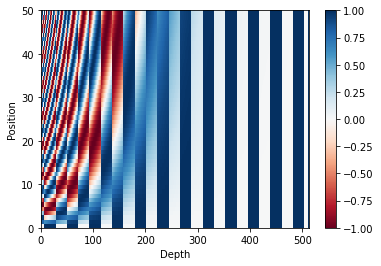

In [40]:
# Position Encoding
print(11//2) 

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates



def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)



pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [41]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [42]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

#example
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [43]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  # -1e9 ~ (-INFINITY) => where ever maks it set, make its logit value close to -INF

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [44]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)

In [45]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model  # typically 512

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [46]:
def point_wise_feed_forward_network(d_model, dff): #dff =512
    return tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
          tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
      ])

In [47]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model) # with Attention

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model) #with Attention

        return out2

In [48]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
          x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'input_vocab_size':self.input_vocab_size,
            'maximum_position_encoding':self.maximum_position_encoding,
            'rate':self.rate
        })
        return config

In [49]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training,look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [50]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'target_vocab_size':self.target_vocab_size,
            'maximum_position_encoding':self.maximum_position_encoding,
            'rate':self.rate
        })
        return config

In [51]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'input_vocab_size':self.input_vocab_size,
            'target_vocab_size':self.target_vocab_size,
            'pe_input':self.pe_input,
            'pe_target':self.pe_target,
            'rate':self.rate
        })
        return config

In [52]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8


input_vocab_size = 30000
target_vocab_size = 30000
dropout_rate = 0.1

In [53]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [54]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

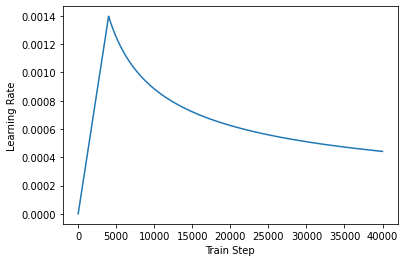

In [55]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [56]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [57]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [58]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [59]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [60]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
  
  
    
    dec_padding_mask = create_padding_mask(inp)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [61]:
checkpoint_path = "./checkpoint"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [62]:
EPOCHS = 10

In [63]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
  
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()
  
    train_loss.reset_states()
    train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))
    
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

# After this checkpoint I kept training the model on a .py file